In [62]:
import time
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Input, Concatenate, Dense, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
from scipy.stats import norm

In [63]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

rng = np.random.RandomState(120)  # For reproducibility of results

# ============================
# Specifying Hyper-parameters:
# ============================

num_epochs = 8000  # Setting the number of training epochs
batch_size = 43  # Setting the size of training batches
num_select = 100  # Amount of data points available

sigma_x1 = 0.2  # Tune how far from original data points is sampled (x1 dimension)
sigma_x2 = 0.2  # Tune how far from original data points is sampled (x2 dimension)
sigma_y = 0.2  # Tune how far from target variables is sampled (y dimension)
mean_prior_weight = 0.05#epistemic
noise_prior_weight = 0.05#aleatoric
# Setting the expected aleatoric noise per dimension [2, 10, 1] shape !!! NOT GENERALIZED !!!
exp_noise_x1 = 0.5
exp_noise_x2 = 0.5
exp_noise_temp = np.tile([exp_noise_x1], (batch_size, 1)), np.tile([exp_noise_x2], (batch_size, 1))
exp_noise_std = tf.constant(exp_noise_temp, dtype=tf.float32)#aleatoric

initial_lr = 0.001  # Setting the learning rate for the optimizer #cambiado de 0.001
decay_rate = 0.5  # Decay of the learning rate scheduler

In [64]:
# =======================
# Creating Training data:
# =======================
f=open('../data/europed_predictions_large.txt',)
data=np.loadtxt('../data/europed_predictions_large.txt',skiprows=1)
columnas=f.readlines()[0].split()
plasma=pd.DataFrame(data=data,columns=columnas)

In [65]:
train,test=train_test_split(plasma.loc[:,['Ip[MA]','Bt[T]','Te_ped_EPED']],test_size=0.3)

In [66]:
# sns.scatterplot(data=plasma,x=' Shot',y='Te_ped_EPED')
train


,Ip[MA],Bt[T],Te_ped_EPED
755,1.9971,2.6558,1.0654
504,1.9861,2.1022,0.7583
750,1.6842,1.9865,0.7281
511,3.4592,3.2266,1.1634
259,1.7023,1.9836,0.7171
...,...,...,...
890,1.3739,1.6549,0.7486
483,1.3751,1.6577,0.5515
274,1.9873,2.0952,0.5687
790,1.3667,1.8660,0.6837


In [67]:

plasma=train

x1_train=tf.constant(plasma.loc[:,'Ip[MA]'].values, dtype=tf.float32)
x1_test=tf.constant(test.loc[:,'Ip[MA]'].values, dtype=tf.float32)

x2_train=tf.constant(plasma.loc[:,'Bt[T]'].values, dtype=tf.float32)
x2_test=tf.constant(test.loc[:,'Bt[T]'].values, dtype=tf.float32)

y_train=tf.constant(plasma.loc[:,'Te_ped_EPED'].values, dtype=tf.float32)
y_test=tf.constant(test.loc[:,'Te_ped_EPED'].values, dtype=tf.float32)

In [68]:
def noise(x1, x2, slope, rng=np.random):
    noise_std = np.maximum(0.0, x1 + x2) * slope
    return rng.normal(0, noise_std).astype(np.float32)
# =========================
# Creating model structure:
# =========================
# Using the 1D-function to convert to a data-space distribution
def mean_dist_fn(variational_layer):
    def mean_dist(inputs):
        bias_mean = variational_layer.bias_posterior.mean()

        kernel_mean = variational_layer.kernel_posterior.mean()
        kernel_std = variational_layer.kernel_posterior.stddev()

        mu_mean = tf.matmul(inputs, kernel_mean) + bias_mean
        mu_var = tf.matmul(inputs ** 2, kernel_std ** 2)
        mu_std = tf.sqrt(mu_var)
        return tfd.Normal(mu_mean, mu_std)

    return mean_dist


def create_model(n_hidden1=200,n_hidden2=200):
    leaky_relu = LeakyReLU(alpha=0.2)
    variational_layer = tfpl.DenseReparameterization(1, name='mu')

    input_x1 = Input(shape=(1,))  # Again, there is probably a better way to structure this
    input_x2 = Input(shape=(1,))  # Again, there is probably a better way to structure this
    input_combined = Concatenate(axis=1)([input_x1, input_x2])
    d_combined = Dense(n_hidden1, input_dim=2, activation=leaky_relu)(input_combined)
    d_combined = Dense(n_hidden2, activation=leaky_relu)(d_combined)
    s1 = Dense(1, activation='softplus', name='sigma1')(d_combined)
    s2 = Dense(1, activation='softplus', name='sigma2')(d_combined)
    m = variational_layer(d_combined)

    mean_dist = Lambda(mean_dist_fn(variational_layer))(d_combined)
    ndim_out = Lambda(lambda p: tfd.MultivariateNormalDiag(loc=p[0],
                                                           scale_diag=[p[1], p[2]]))((m, s1, s2))
    return Model([input_x1, input_x2], [ndim_out, mean_dist])


model = create_model()


# =======================================
# Creating model training infrastructure:
# =======================================
def lr_scheduler(decay_steps):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate)


def optimizer_function(lr):
    return tf.keras.optimizers.Adam(learning_rate=lr)


def data_loader(x1, x2, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x1, x2, y))
    ds = ds.shuffle(x1.shape[0])
    return ds.batch(batch_size)


def data_loader2(x, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(x.shape[0])
    return ds.batch(batch_size)


def backprop(model, loss, tape):
    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    return zip(gradients, trainable_vars)
# The function below uses a lot of manually shaped tensors, so careful generalization is needed
@tf.function
def NCP_train_step(model, optimizer, x1, x2, y):
    # Format input data
    y_reshape = tf.reshape(y, [batch_size, 1])  # MANUAL RESHAPING
    y_nll = [y_reshape, y_reshape]  # MANUAL RESHAPING

    # Generate random OOD data from training data
    ood_x1 = x1 + tf.random.normal(tf.shape(x1), stddev=sigma_x1)
    ood_x2 = x2 + tf.random.normal(tf.shape(x2), stddev=sigma_x2)

    # NCP output prior
    ood_mean_prior = tfd.Normal(y_reshape, sigma_y)

    with tf.GradientTape() as tape:
        # For train data inputs
        ndim_dist, mean_dist = model([x1, x2], training=True)

        # For OOD data inputs
        ood_ndim_dist, ood_mean_dist = model([ood_x1, ood_x2], training=True)

        # A single combined Negative Log-Likelihood for all dimensions
        nll = -ndim_dist.log_prob(y_nll)
        nll_reshape = tf.reshape(nll, [2, batch_size, 1])  # MANUAL RESHAPING

        # KL divergence between output prior and OOD mean distribution
        kl_ood_mean = tfd.kl_divergence(ood_mean_prior, ood_mean_dist)
        kl_ood_mean_reshape = tf.reshape(kl_ood_mean, [1, batch_size, 1])  # MANUAL RESHAPING

        # Encouraging aleatoric uncertainty to be a set amount for OOD data
        exp_noise_dist = tfd.MultivariateNormalDiag(loc=0, scale_diag=exp_noise_std)
        meas_noise_dist = tfd.MultivariateNormalDiag(loc=0, scale_diag=ood_ndim_dist.stddev())

        # KL-Divergence between the noise distributions to fit towards the prior:
        kl_ood_noise = tfd.kl_divergence(exp_noise_dist, meas_noise_dist)
        kl_ood_noise_reshape = tf.reshape(kl_ood_noise, [2, batch_size, 1])  # MANUAL RESHAPING

        # Calculate the combined loss term
        loss = tf.reduce_sum(
            nll_reshape + mean_prior_weight * kl_ood_mean_reshape + noise_prior_weight * kl_ood_noise_reshape)
        nll=tf.reduce_sum(nll_reshape)
        epistemic_loss=tf.reduce_sum(kl_ood_mean_reshape)
        aleatoric_loss=tf.reduce_sum(kl_ood_noise_reshape)

    optimizer.apply_gradients(backprop(model, loss, tape))
    return loss, mean_dist.mean(),epistemic_loss, aleatoric_loss, nll

def train(model, x1, x2,y, batch_size, epochs, step_fn,eval_set=[x1_test,x2_test,y_test]):
    steps_per_epoch = int(np.ceil(y.shape[0] / batch_size))
    steps = epochs * steps_per_epoch

    scheduler = lr_scheduler(steps)
    optimizer = optimizer_function(scheduler)
    loader = data_loader(x1, x2, y, batch_size=batch_size)

    loss_tracker = tf.keras.metrics.Mean(name='loss')
    mse_tracker = tf.keras.metrics.MeanSquaredError(name='mse')

    loss_list = []
    mse_list = []
    mse_test=[]
    epi=[]
    alea=[]
    nll_list=[]

    for epoch in range(1, epochs + 1):
        for x1_batch, x2_batch, y_batch in loader:
            loss, y_pred, epi_loss, alea_loss, nll = step_fn(model, optimizer, x1_batch, x2_batch, y_batch)

            loss_tracker.update_state(loss)
            mse_tracker.update_state(y_batch, y_pred)

        loss_list.append(loss_tracker.result().numpy())
        mse_list.append(mse_tracker.result().numpy())
        y_pred_test=model([eval_set[0],eval_set[1]])[1].mean()
        mse_t=mean_squared_error(eval_set[2],y_pred_test)
        mse_test.append(mse_t)
        epi.append(epi_loss)
        alea.append(alea_loss)
        nll_list.append(nll)
        

        if 1 and epoch % 20 == 0:
            print(f'epoch {epoch}: loss = {loss_tracker.result():.3f}, mse = {mse_tracker.result():.3f}, mse_test = {mse_t:.3f}, epi={epi_loss:.3f}, alea={alea_loss:.3f}, nll={nll:.3f}')
        loss_tracker.reset_states()
        mse_tracker.reset_states()
    metric_tensor = [loss_list, mse_list,mse_test,epi,alea,nll_list]
    return metric_tensor
    


C:\Users\paner\Anaconda3\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.



In [69]:
# model.load_weights('../weights/BNN_v11')

In [70]:
# model.load_weights('../weights/BNN_0,05_2D')

In [71]:
history = train(model, x1_train, x2_train, y_train, batch_size=batch_size, epochs=1000, step_fn=NCP_train_step,eval_set=[x1_test,x2_test,y_test])

In [73]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2)            0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 200)          600         concatenate_3[0][0]        

In [11]:
# model.save_weights('../weights/BNN_v11')

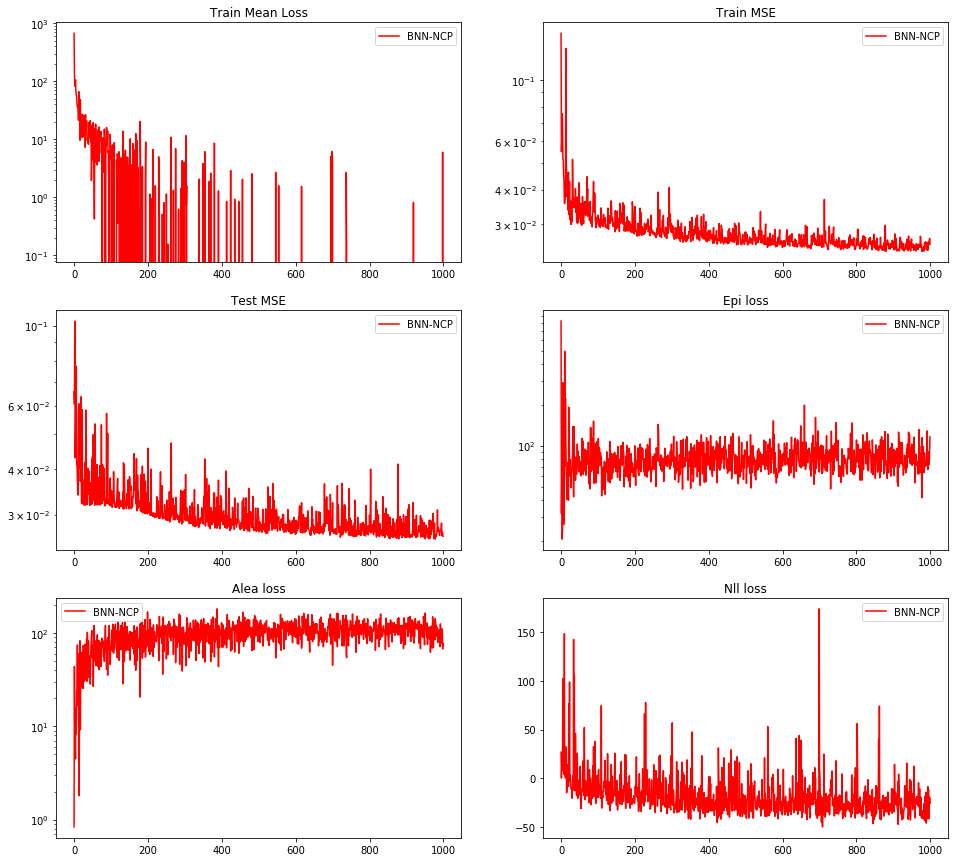

In [20]:
# Plotting training performance
fig = plt.figure(figsize=(16, 15))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6=fig.add_subplot(326)
ax.set_title("Train Mean Loss")
ax.plot(history[0], color='red', label='BNN-NCP',scaley='log')
ax.set_yscale('log')
ax.legend()

ax2.set_title("Train MSE")
ax2.plot(history[1], color='red', label='BNN-NCP')
ax2.set_yscale('log')
ax2.legend()

ax3.set_title("Test MSE")
ax3.plot(history[2], color='red', label='BNN-NCP')
ax3.set_yscale('log')
ax3.legend()
ax4.set_title("Epi loss")
ax4.plot(history[3], color='red', label='BNN-NCP')
ax4.set_yscale('log')
ax4.legend()
ax5.set_title("Alea loss")
ax5.plot(history[4], color='red', label='BNN-NCP')
ax5.set_yscale('log')
ax5.legend()

ax6.set_title("Nll loss")
ax6.plot(history[5], color='red', label='BNN-NCP')
# ax6.set_yscale('log')
ax6.legend()



plt.show(block=False)

In [22]:
ndim_out_dist, mean_dist=model([tf.constant(plasma['Ip[MA]'].values,dtype=tf.float32),tf.constant(plasma['Bt[T]'].values,dtype=tf.float32)])

In [23]:
z_epi = mean_dist.stddev().numpy()
alea_uncertainty = np.add(ndim_out_dist[0].stddev().numpy(), ndim_out_dist[1].stddev().numpy())

C:\Users\paner\Anaconda3\lib\site-packages\tensorflow_probability\python\distributions\internal\slicing.py:140: UserWarning:

Unable to find property getter for parameter Tensor scale_diag on tfp.distributions.MultivariateNormalDiag("model_lambda_1_MultivariateNormalDiag", batch_shape=[2, 688], event_shape=[1], dtype=float32), falling back to Distribution.dtype <dtype: 'float32'>



In [24]:
B=np.linspace(0,4,1000)
ndim_out_dist_B, mean_dist_B=model([tf.constant(np.full(B.shape,1.5),dtype=tf.float32),tf.constant(B,dtype=tf.float32)])
z_epi_B = mean_dist_B.stddev().numpy()
alea_uncertainty_B = np.add(ndim_out_dist_B[0].stddev().numpy(), ndim_out_dist_B[1].stddev().numpy())

C:\Users\paner\Anaconda3\lib\site-packages\tensorflow_probability\python\distributions\internal\slicing.py:140: UserWarning:

Unable to find property getter for parameter Tensor scale_diag on tfp.distributions.MultivariateNormalDiag("model_lambda_1_MultivariateNormalDiag", batch_shape=[2, 1000], event_shape=[1], dtype=float32), falling back to Distribution.dtype <dtype: 'float32'>



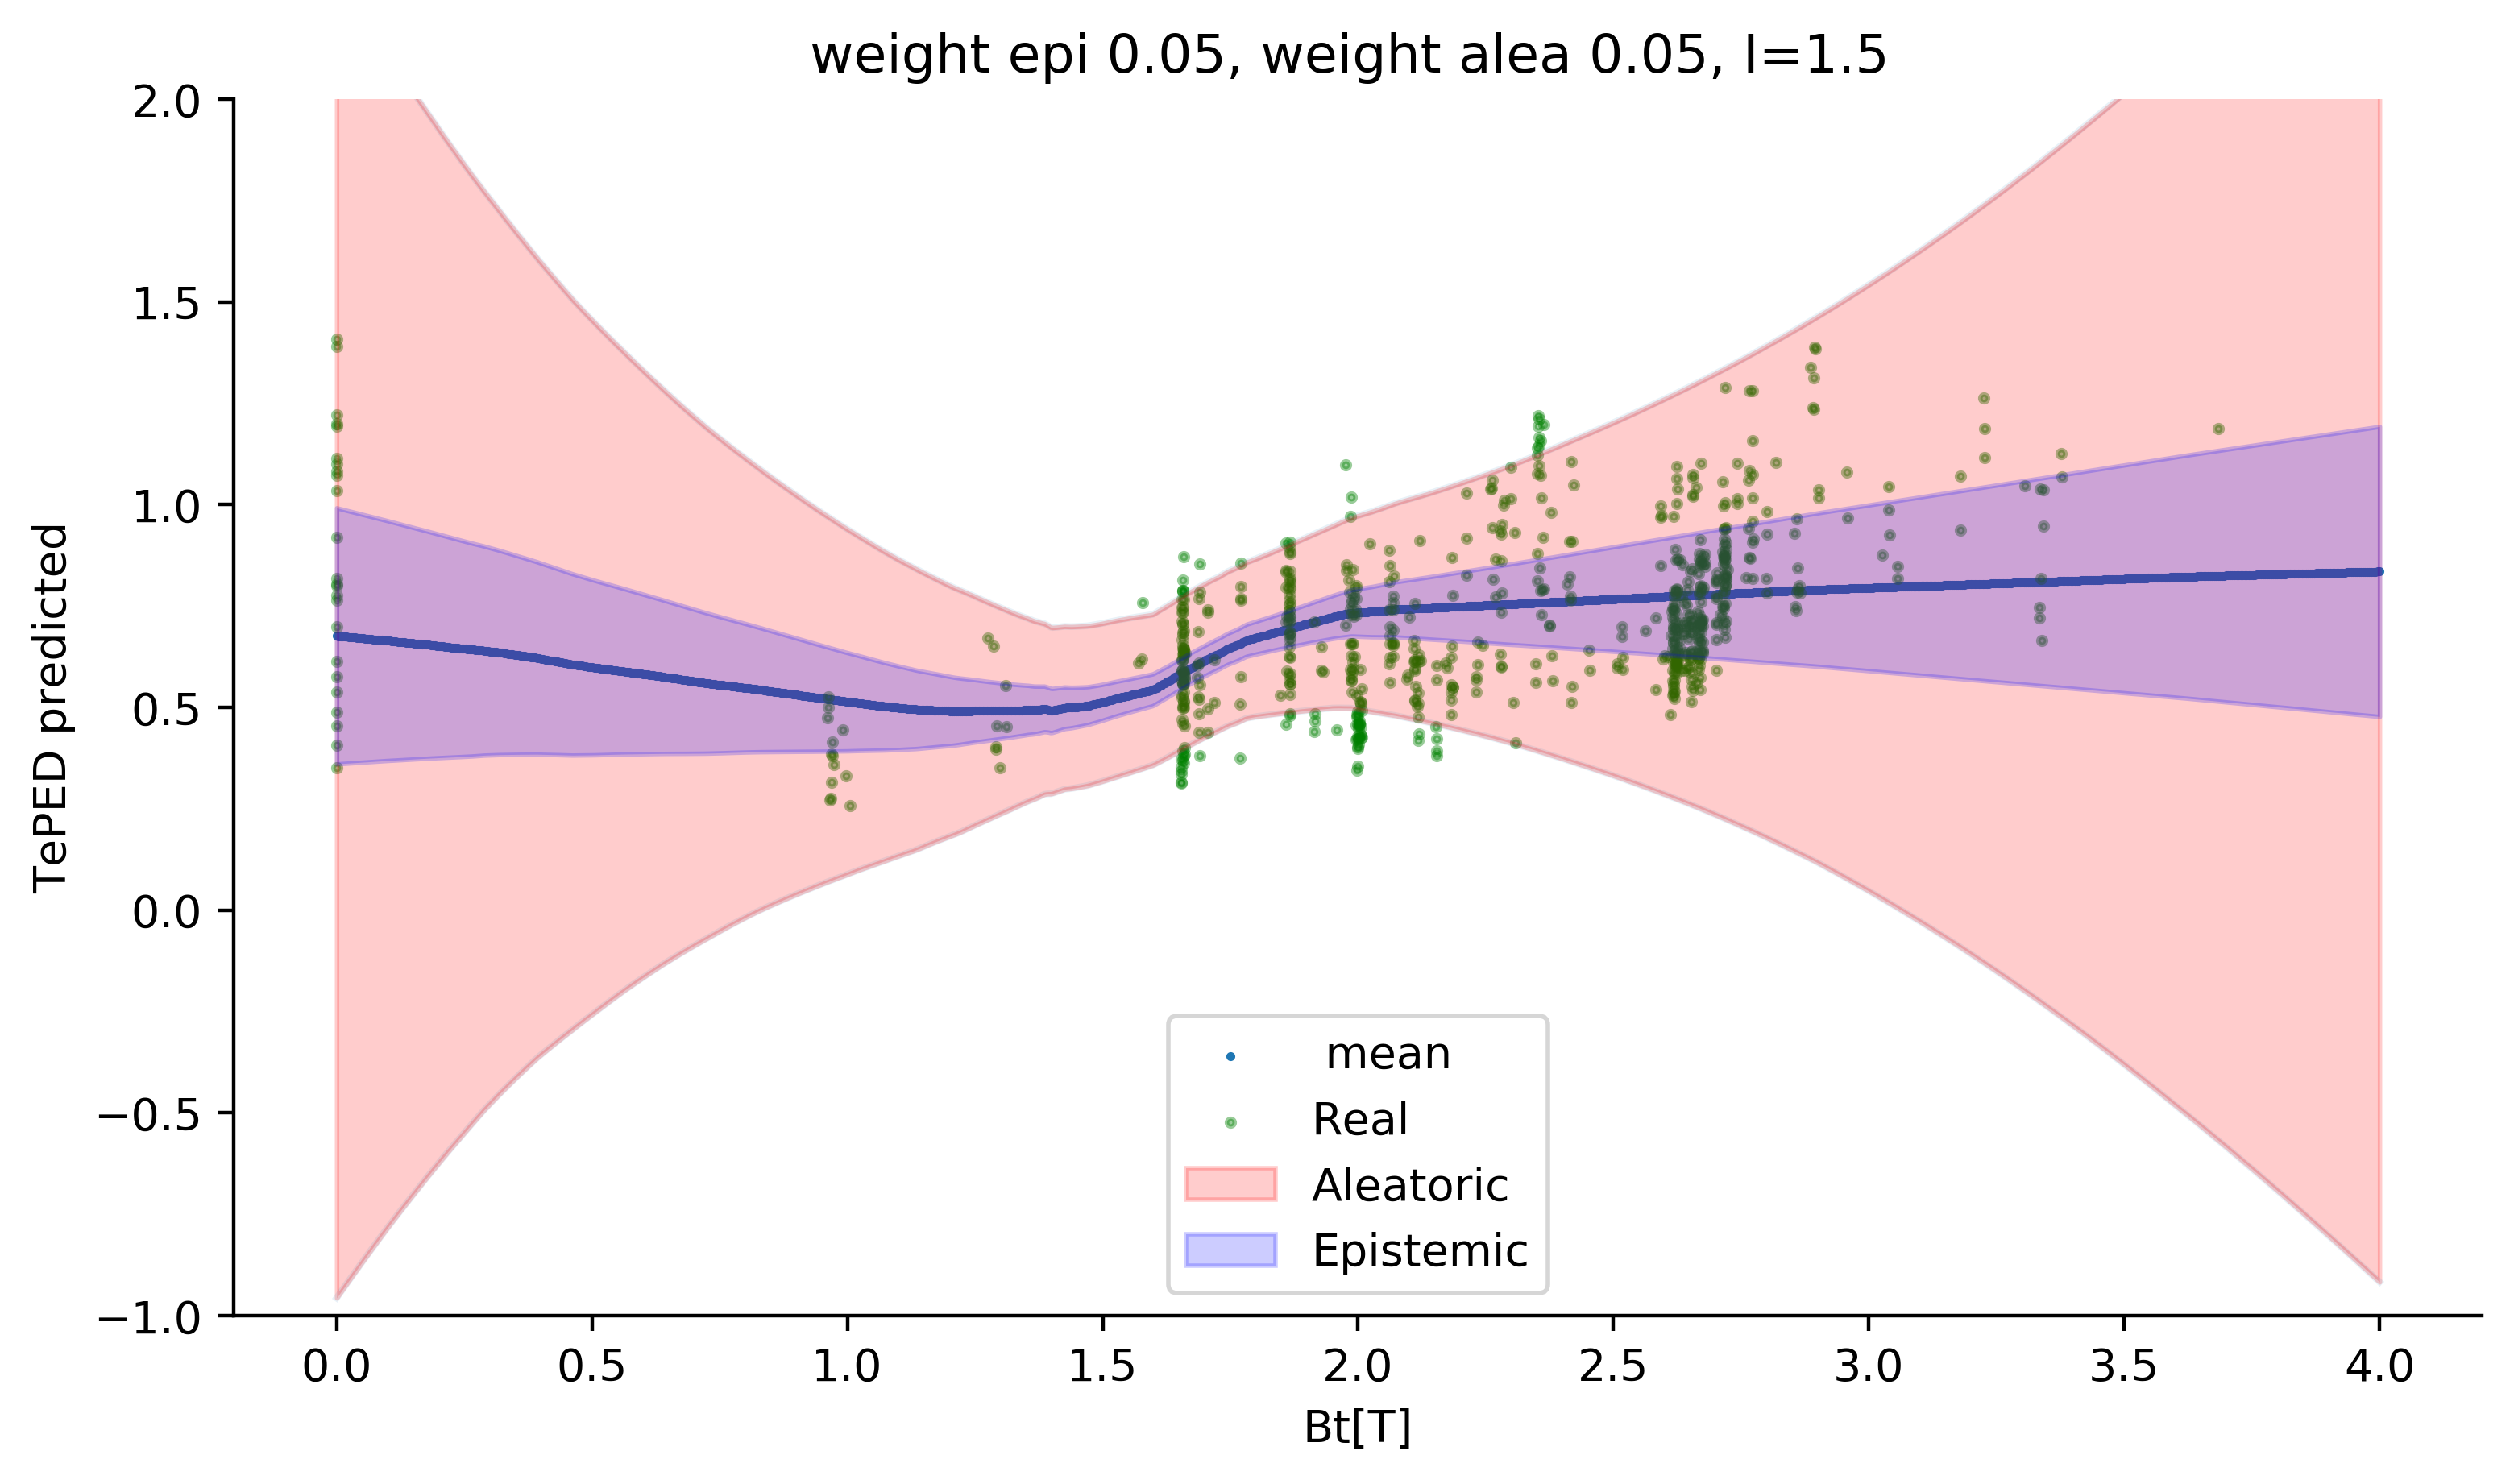

In [25]:
df=pd.DataFrame({'x':B, 'mean':mean_dist_B.mean().numpy()[:,0], 'alea':alea_uncertainty_B[:,0],'epi':z_epi_B[:,0]}).sort_values(by='x')
x_1=plasma['Bt[T]'].values
df_1=pd.DataFrame({'x':x_1,'Te':plasma['Te_ped_EPED']})
error = 0.5*df.alea.values
error2=0.5*df.epi.values
lower = df['mean'].values - error
upper = df['mean'].values + error
lower2 = df['mean'].values - error2
upper2 = df['mean'].values + error2
fig, ax = plt.subplots(figsize=(9,5),dpi=400)

ax.scatter(df.x, df['mean'], label=' mean',s=1)
ax.plot(df.x, lower, color='tab:blue', alpha=0.1)
ax.plot(df.x, upper, color='tab:blue', alpha=0.1)
ax.scatter(df_1.x,df_1.Te,color='g',s=3,alpha=0.4,label='Real')
# ax.plot(np.array([0,1.4]),np.array([0,1.4]))
ax.fill_between(df.x, lower, upper,color='r', alpha=0.2,label='Aleatoric')
ax.fill_between(df.x, lower2, upper2,color='b', alpha=0.2,label='Epistemic')

ax.set_xlabel('Bt[T]')
ax.set_ylabel('TePED predicted')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('weight epi 0.05, weight alea 0.05, I=1.5 ')
plt.ylim(-1,2)
plt.legend()
# plt.savefig('../figures/B_vs_Te_epi0.05_alea0.05.jpg')
plt.show()

In [26]:
# model.save_weights('../weights/BNN_0,05_2D')

In [27]:
# ndim_out_dist.log_prob(y_nll)
y=plasma['Te_ped_EPED']
y_reshape = tf.reshape(y, [y.shape[0], 1])  # MANUAL RESHAPING
y_nll = [y_reshape, y_reshape]
ndim_out_dist.log_prob(y_nll)

<tf.Tensor: shape=(2, 688), dtype=float32, numpy=
array([[0.6729362 , 0.7098338 , 0.26618302, ..., 0.6839608 , 0.5471493 ,
        0.7734985 ],
       [0.67739344, 0.70658237, 0.25711071, ..., 0.6866665 , 0.5401888 ,
        0.760573  ]], dtype=float32)>

In [28]:
plasma

,Ip[MA],Bt[T],Te_ped_EPED
567,1.6669,1.7180,0.6171
558,1.9770,2.0685,0.7742
737,3.1771,2.9573,1.0797
311,3.1807,2.7730,0.8185
337,2.4819,2.7090,0.7274
...,...,...,...
942,3.1699,2.9589,0.9661
168,0.9806,0.9624,0.5256
770,2.4694,2.6391,0.7578
3,1.3673,1.6559,0.5915


C:\Users\paner\Anaconda3\lib\site-packages\tensorflow_probability\python\distributions\internal\slicing.py:140: UserWarning:

Unable to find property getter for parameter Tensor scale_diag on tfp.distributions.MultivariateNormalDiag("model_lambda_1_MultivariateNormalDiag", batch_shape=[2, 2500], event_shape=[1], dtype=float32), falling back to Distribution.dtype <dtype: 'float32'>



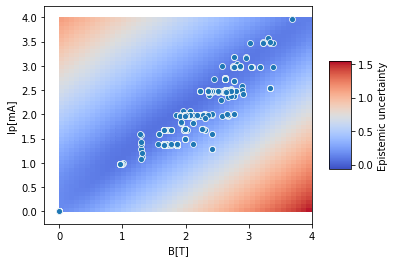

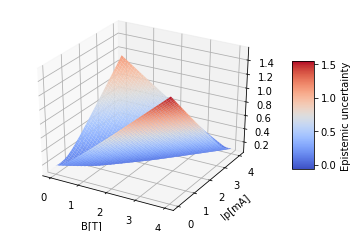

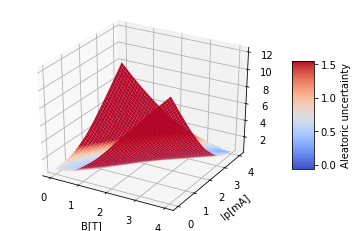

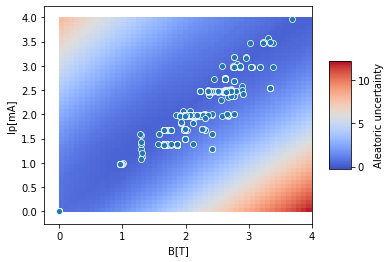

In [29]:
# The test data range
x1_test=np.linspace(0,4,50,dtype=np.float32)#I
x2_test=np.linspace(0,4,50,dtype=np.float32)#B
m1_test, m2_test = np.meshgrid(x1_test, x2_test)

# Custom grid since we need to evaluate each x1, x2 pair individually
# There is probably a better way to do this by changing the model input structure
grid_1 = []
for x1 in x1_test:
    grid_1.append(len(x2_test) * [x1])
grid_input_1 = tf.reshape(grid_1, [len(x1_test) * len(x2_test)])
grid_input_2 = tf.constant(np.tile(x2_test, len(x1_test)), dtype=tf.float32)

# Extracting the model predictions
ndim_out_dist, mean_dist = model([grid_input_1, grid_input_2])

epi_uncertainty = mean_dist.stddev()
z_epi = tf.reshape(epi_uncertainty, [50, 50]).numpy()
z_epi = z_epi[:, :]
z_epi_min = -z_epi.min()
z_epi_max = z_epi.max()

alea_uncertainty = np.add(ndim_out_dist[0].stddev().numpy(), ndim_out_dist[1].stddev().numpy())
z_alea = tf.reshape(alea_uncertainty, [50, 50]).numpy()
z_alea = z_alea[:, :]
z_alea_min = -z_alea.min()
z_alea_max = z_alea.max()

# Plotting 2D top-down overviews of both the aleatoric and the epistemic uncertainties
fig = plt.figure()
surf = plt.pcolor(m2_test, m1_test, z_epi, cmap=cm.coolwarm, vmin=z_epi_min, vmax=z_epi_max)
sns.scatterplot(data=plasma,x='Bt[T]',y='Ip[MA]')
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Epistemic uncertainty')
plt.xlabel('B[T]')
plt.ylabel('Ip[mA]')
plt.show(block=False)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(m2_test, m1_test, z_epi, cmap=cm.coolwarm, vmin=z_epi_min, vmax=z_epi_max)
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Epistemic uncertainty')
plt.xlabel('B[T]')
plt.ylabel('Ip[mA]')
plt.show(block=False)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(m2_test, m1_test, z_alea, cmap=cm.coolwarm, vmin=z_epi_min, vmax=z_epi_max)
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Aleatoric uncertainty')
plt.xlabel('B[T]')
plt.ylabel('Ip[mA]')
plt.show(block=False)

fig = plt.figure()
surf = plt.pcolor(m2_test, m1_test, z_alea, cmap=cm.coolwarm, vmin=z_alea_min, vmax=z_alea_max)
sns.scatterplot(data=plasma,x='Bt[T]',y='Ip[MA]')
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Aleatoric uncertainty')
plt.xlabel('B[T]')
plt.ylabel('Ip[mA]')
plt.show()

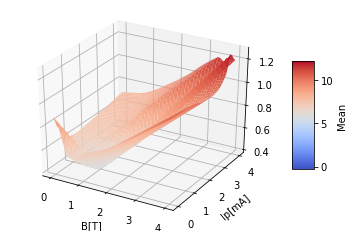

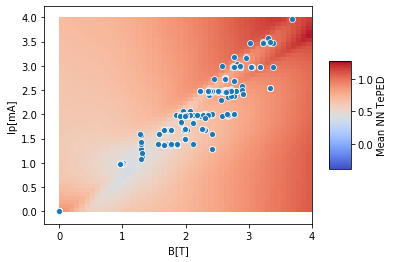

In [30]:
teped_mean = mean_dist.mean()
z_mean = tf.reshape(teped_mean, [50, 50]).numpy()
z_mean = z_mean[:, :]
z_mean_min = -z_mean.min()
z_mean_max = z_mean.max()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(m2_test, m1_test, z_mean, cmap=cm.coolwarm, vmin=z_mean_min, vmax=z_mean_max)
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Mean')
plt.xlabel('B[T]')
plt.ylabel('Ip[mA]')
plt.show(block=False)
fig = plt.figure()
surf = plt.pcolor(m2_test, m1_test, z_mean, cmap=cm.coolwarm, vmin=z_mean_min, vmax=z_mean_max)
sns.scatterplot(data=plasma,x='Bt[T]',y='Ip[MA]',palette='Set2')
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Mean NN TePED')
plt.xlabel('B[T]')
plt.ylabel('Ip[mA]')
plt.show()

In [31]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

z = z_epi
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 4, sh_0), np.linspace(0, 4, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y,colorscale="oryel")])
fig.update_layout(title='Epistemic', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                    xaxis_title='Ip[mA]',
                    yaxis_title='B[T]',
                    zaxis_title='Epistemic Uncertainty'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()
z = z_alea
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 4, sh_0), np.linspace(0, 4, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y,colorscale="oryel")])
fig.update_layout(title='Aleatoric', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                    xaxis_title='Ip[mA]',
                    yaxis_title='B[T]',
                    zaxis_title='Aleatoric Uncertainty'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()


In [32]:
import plotly.graph_objects as go
z=z_mean
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 4, sh_0), np.linspace(0, 4, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y,colorscale="oryel")])
fig.update_layout(title='TePED BNN-NCP', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_layout(scene = dict(
                    xaxis_title='Ip[mA]',
                    yaxis_title='B[T]',
                    zaxis_title='Mean TePED'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

In [33]:
# y_std = df.groupby('timepoint').std()['signal']}
j=688
x=plasma['Bt[T]'].values[0:j]
B=np.linspace(0,4,1000)
ndim_out_dist_B, mean_dist_B=model([tf.constant(np.full(B.shape,1.5),dtype=tf.float32),tf.constant(B,dtype=tf.float32)])
df=pd.DataFrame({'x':x,'Te':plasma['Te_ped_EPED'], 'mean':mean_dist.mean().numpy()[0:j,0], 'alea':alea_uncertainty[0:j,0],'epi':z_epi[0:j,0]}).sort_values(by='x')
error = 0.5*df.alea.values
error2=0.5*df.epi.values
lower = df['mean'].values - error
upper = df['mean'].values + error
lower2 = df['mean'].values - error2
upper2 = df['mean'].values + error2
fig, ax = plt.subplots(figsize=(9,5),dpi=400)

ax.scatter(df.x, df['mean'], label=' mean',s=1)
ax.plot(df.x, lower, color='tab:blue', alpha=0.1)
ax.plot(df.x, upper, color='tab:blue', alpha=0.1)
ax.scatter(df.x,df.Te,color='g',s=3,alpha=0.4,label='Real')
# ax.plot(np.array([0,1.4]),np.array([0,1.4]))
ax.fill_between(df.x, lower, upper,color='r', alpha=0.2,label='Aleatoric')
ax.fill_between(df.x, lower2, upper2,color='b', alpha=0.2,label='Epistemic')

ax.set_xlabel('Bt[T]')
ax.set_ylabel('TePED predicted')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

ValueError: arrays must all be same length

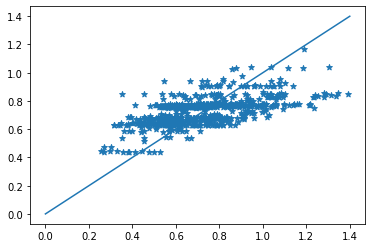

In [ ]:
plt.scatter(x=plasma['Te_ped_EPED'],y=mean_dist.mean(),marker='*')
plt.plot(np.array([0,1.4]),np.array([0,1.4]))

In [ ]:
m1_test=test['Ip[MA]'].values
m2_test=test['Bt[T]'].values
epi_uncertainty = mean_dist.stddev()
z_epi = tf.reshape(epi_uncertainty, [50, 50]).numpy()
# z_epi = z_epi[:-1, :-1]
z_epi_min = -z_epi.min()
z_epi_max = z_epi.max()

alea_uncertainty = np.add(ndim_out_dist[0].stddev().numpy(), ndim_out_dist[1].stddev().numpy())
z_alea = tf.reshape(alea_uncertainty, [50, 50]).numpy()
z_alea = z_alea[:-1, :-1]
z_alea_min = -z_alea.min()
z_alea_max = z_alea.max()

# Plotting 2D top-down overviews of both the aleatoric and the epistemic uncertainties
fig = plt.figure()
surf = plt.pcolor(m2_test, m1_test, z_epi, cmap=cm.coolwarm, vmin=z_epi_min, vmax=z_epi_max)
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Epistemic uncertainty')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.show(block=False)

fig = plt.figure()
surf = plt.pcolor(m2_test, m1_test, z_alea, cmap=cm.coolwarm, vmin=z_alea_min, vmax=z_alea_max)
col_bar = fig.colorbar(surf, shrink=0.5, aspect=5)
col_bar.set_label('Aleatoric uncertainty')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.show()

InvalidArgumentError: Input to reshape is a tensor with 688 values, but the requested shape has 2500 [Op:Reshape]